In [1]:
import pandas as pd
import pymysql
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)

# Get Data

In [2]:
def get_data():
    host = "db4free.net"
    port = 3306
    user = "rootjingen"
    password = "password"
    database = "is3107"

    conn = pymysql.connect(host=host, port=port, user=user, password=password, database=database)
    cur = conn.cursor()
    cur.execute("SELECT * FROM job_database")
    rows = cur.fetchall()

    # get the column names from the cursor description
    col_names = [desc[0] for desc in cur.description]

    cur.close()
    conn.close()

    df = pd.DataFrame(rows, columns = col_names)
    return df

In [3]:
df = get_data()

# Removing Duplicates

To remove duplicates, we process our dataframe in three steps:
1. We remove those with similar job posting URLs. This helps to remove duplicates *within* the same job portal. **Example:** When we search for Data Analyst and Data Scientist, both searches return the same job posting, since the same job posting can have multiple tags.

2. We then use Pandas drop_duplicate function, using the columns job_title and company_name. This helps to remove duplicates *across* different job portals. **Example:** A company looking for a Data Analyst posts on both Indeed and Glassdoor.
**Example:** For Jobstreet, the URL contains the rank of the post, which is different across different queries but direct to the exact same posting.

3. Lastly, we use cosine similarity to remove similar rows. This helps to remove duplicates *within & across* the same job portal. **Example:** when a company does repeated posts, perhaps with a few months interval, but with slightly different titles. The titles could be "Data Analyst" and "Data Analyst! Hiring urgently!".

Using these three layers of data removal, we ensure our data is cleaned thoroughly and that no duplicates will disproportionately skew the results in our downstream analysis.

### First Layer: Removing using URL

In [4]:
before = len(df)
df = df.drop_duplicates(subset="url", keep="first")
after = len(df)
print("Length of dataframe dropped by {} to {} after removing by URL.".format(before,after))

Length of dataframe dropped by 4341 to 4341 after removing by URL.


### Second Layer: Removing using drop_duplicates

In [5]:
cols_to_check = ['job_title', 'company_name']
dropped_rows = df[df.duplicated(subset=cols_to_check, keep=False)].sort_values(by=cols_to_check)
dropped_rows["website"].value_counts()

Series([], Name: website, dtype: int64)

In [6]:
print("Example of similar postings with different URLs due to different searched job titles, resulting in different ranks within the URL.")
pd.DataFrame(dropped_rows.iloc[0:2])

Example of similar postings with different URLs due to different searched job titles, resulting in different ranks within the URL.


,job_title,searched_job_title,company_name,salary_lower_bound,salary_upper_bound,salary_frequency,job_type,website,url


In [7]:
cols_to_check = ['job_title', 'company_name']
before = len(df)
df = df.drop_duplicates(subset=cols_to_check, keep="first")
after = len(df)
print("Length of dataframe dropped by {} to {} after removing by job_title and company_name.".format(before,after))

Length of dataframe dropped by 4341 to 4341 after removing by job_title and company_name.


### Third Layer: Removing using cosine similarity

In [8]:
new_df = df.copy()
columns_to_concat = ['job_title', 'company_name', 'salary_lower_bound', 'salary_upper_bound', 'salary_frequency', 'job_type']
new_df = df[columns_to_concat].copy()
new_df['combined'] = new_df.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
vectorizer = CountVectorizer().fit_transform(new_df['combined'])
cosine_sim = cosine_similarity(vectorizer)

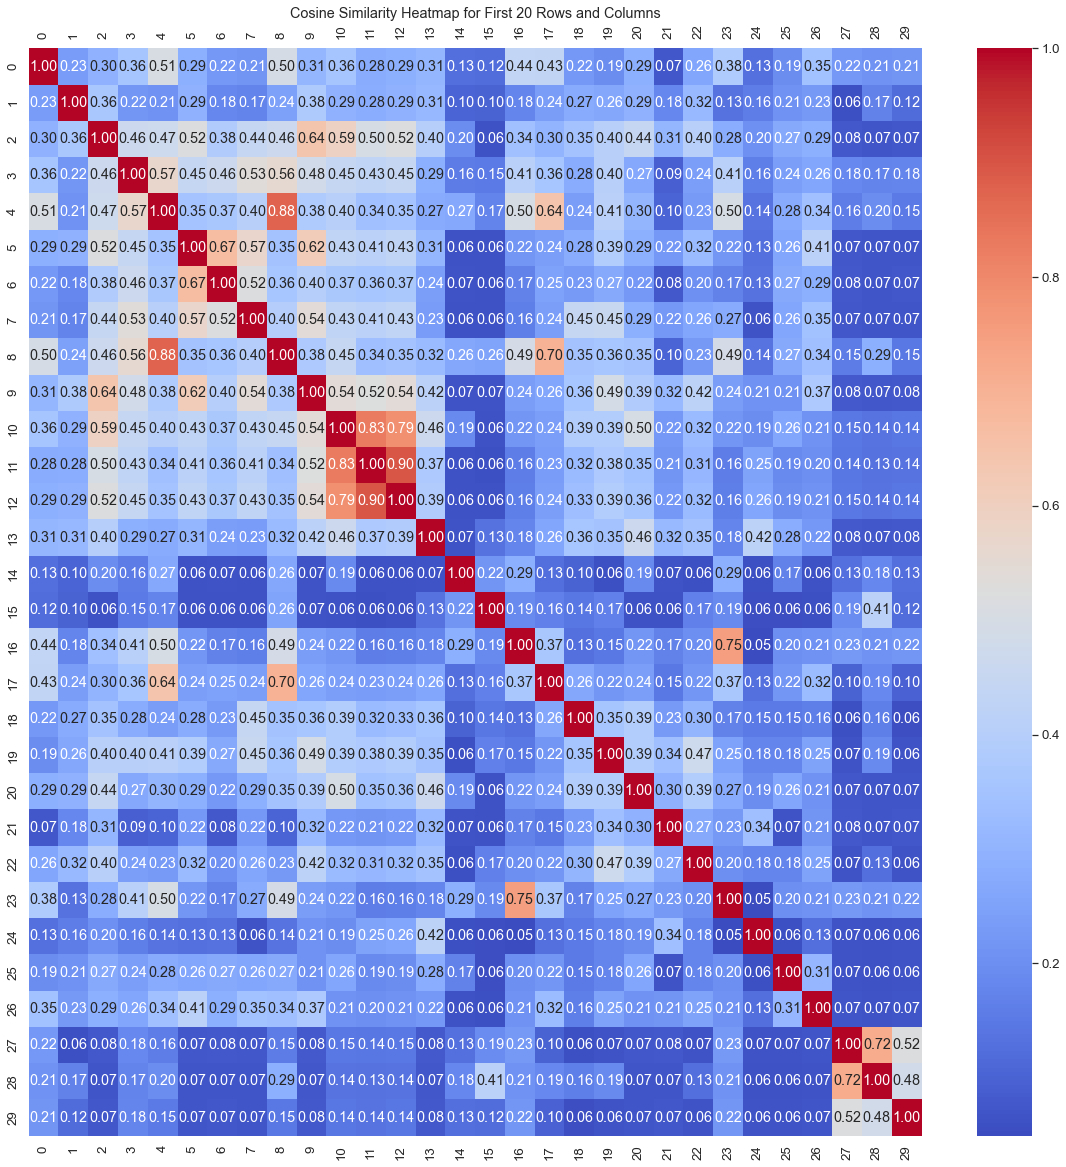

In [9]:
plt.figure(figsize=(20,20))
cosine_sim_subset = cosine_sim[:30,:30]
sns.set(font_scale=1.2)
sns.heatmap(cosine_sim_subset, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Cosine Similarity Heatmap for First 20 Rows and Columns")
plt.tick_params(axis='x', labelrotation=90, labeltop=True, bottom=False)
plt.show()

In [10]:
print("Example: Similar job posting, slightly different job titles. One of these should be removed.")
pd.DataFrame(new_df.iloc[4376:4378])

Example: Similar job posting, slightly different job titles. One of these should be removed.


,job_title,company_name,salary_lower_bound,salary_upper_bound,salary_frequency,job_type,combined


In [11]:
threshold_value = 0.90

# get indices of rows that have cosine similarity score of >= 0.90
duplicates = []
for i in range(len(cosine_sim)):
    for j in range(i+1, len(cosine_sim)):
        if cosine_sim[i][j] >= threshold_value and \
          (df.iloc[i]["salary_lower_bound"] == df.iloc[j]["salary_lower_bound"]) and \
          (df.iloc[i]["salary_upper_bound"] == df.iloc[j]["salary_upper_bound"]):
            duplicates.append(j)

before = len(df)
df = df.drop(df.index[duplicates])
after = len(df)
print("Length of dataframe dropped by {} to {} after removing by cosine similarity and salary.".format(before,after))

Length of dataframe dropped by 4341 to 4340 after removing by cosine similarity and salary.


In [12]:
def remove_duplicates(df):
    before = len(df)
    # First Layer: Removing using URL
    df = df.drop_duplicates(subset="url", keep="first")
    # Second Layer: Removing using drop_duplicates
    cols_to_check = ['job_title', 'company_name']
    df = df.drop_duplicates(subset=cols_to_check, keep="first")
    # Third Layer: Removing using cosine similarity
    new_df = df.copy()
    columns_to_concat = ['job_title', 'company_name', 'salary_lower_bound', 'salary_upper_bound', 'salary_frequency', 'job_type']
    new_df = df[columns_to_concat].copy()
    new_df['combined'] = new_df.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
    vectorizer = CountVectorizer().fit_transform(new_df['combined'])
    cosine_sim = cosine_similarity(vectorizer)
    threshold_value = 0.90
    duplicates = []
    for i in range(len(cosine_sim)):
        for j in range(i+1, len(cosine_sim)):
            if cosine_sim[i][j] >= threshold_value and \
              (df.iloc[i]["salary_lower_bound"] == df.iloc[j]["salary_lower_bound"]) and \
              (df.iloc[i]["salary_upper_bound"] == df.iloc[j]["salary_upper_bound"]):
                duplicates.append(j)
    df = df.drop(df.index[duplicates])
    after = len(df)
    print("Length of df reduced from {} to {}.".format(before, after))
    return df

In [13]:
df = get_data()
cleaned_df = remove_duplicates(df)

Length of df reduced from 4341 to 4340.


The dataset has already had duplicates removed. This ipynb is only to show our methodology.